In [ ]:
# default_exp primitives

# Primitives

> Implementations for vertex, edges, cell(s), and cell monolayer

In [ ]:
#hide
from nbdev.showdoc import *

- `Vertex`: stores 2D position of a given vertex 1x2 numpy array. Should implement a method for distance calculation.
- `Edges`: edges connecting vertices
- `Cell` : a subset of vertices that represents a cell. Implements area, and perimeter calculations.
- `Monolayer`: stores cells, with their corresponding vertices, edges, and boundary conditions. Also should implement energy calculation together with its spatial gradient.

In [ ]:
#export
import torch
import numpy as np
class Vertex(object):
    '''Implements vertex and stores vertex position(s) as Nx2 (or any 2-D tensor) `torch.Tensor`:(x,y,...)'s.
    Rows represent points, columns the spatial dimensions, i.e. `[[x1,y1], [x2,y2], ...,[xN,yN]]`
    
    - Methods:
        - `dist(self,other)` : calculates Euclidean distance between two points (each row).
        - `zero_grad_(self)` : set all gradients to zero (used during gradient descent at each iter-n step).
        - `grad(self)` : get gradient w.r.t. each tensor in `self.x`
    - Properties :
        - `x` : use it to set/get location torch.tensor (returns or modifies self._x)
    '''
    def __init__(self,location=None,**kwargs):
        '''`location` must be (or convertible to)  2D `torch.tensor` w/ float dtype, set and get `location` with self.x
        
        Usage:
        `v = Vertex(torch.tensor([[3.,-1.]],requires_grad=True,dtype=torch.float64))`
        '''
        if location is not None:
            if type(location) is list:
                location = torch.tensor(location,**kwargs)
            elif type(location) is np.ndarray:
                location = torch.from_numpy(location)
            assert location.ndim==2, f"Input 'location' has wrong dimensions, location.ndim!=2 :'( "
        self._x=location
    
    def dist(self,other):
        ''' Calculate (Euclidean) distance to another vertex from self._x.'''
        return torch.norm(other.x - self._x,dim=1,p=2,keepdim=True)
    
    def subloc(self,other):
        '''Subtract locations, self._x-other.x. Returns `torch.tensor`'''
        return self._x-other.x
    
    def zero_grad_(self):
        '''set gradients to zero if x.requires_grad==True'''
        if self._x.grad is not None:
            self._x.grad.data.zero_()
    
    def grad(self):
        '''Get accumulated gradients w.r.t. x (calculated with backprop; `torch.autograd`)'''
        if self._x.grad is not None:
            return self._x.grad
    
    @property
    def x(self):
        return self._x
    @x.setter
    def x(self, val):
        self._x = val
    
    def __str__(self):
        return f"{self._x.tolist()}"
    def __repr__(self):
        return f"Vertex {self._x}"
    

Initialization and calculating distances between vertices:
- When you initialize vertices with no input `v = Vertex()`, the location `v.x` is set to `None`.
- `Vertex(location)` accepts `torch.tensors`, list of lists that are convertible to tensors (with optional keyword arg-s for `torch.tensor()`), numpy.ndarrays (using `torch.from_numpy()`)
- `Vertex.x` (i.e. location) is assumed to be Nx2 array (or any 2D array), and sizes are __not__ checked when set using `self.x`.

In [ ]:
# Define vertices with Nx2 torch tensors
o=Vertex()
o.x=torch.tensor([0.,0.]) # set to 0's (origin)
# or with location at init
v1=Vertex([[1.,1.]],dtype=torch.float32)
# calculate distance between vertices
r = o.dist(v1)
print(f"Distance between two vertices (o <--> v1) : {r.numpy().squeeze()}")

Distance between two vertices (o <--> v1) : 1.4142135381698608


Computing and resetting gradients:
- Example below demonstrates computing $\partial y/\partial v_{i,j}$ for $y = \sum_i\sum_j v_{i,j}^2$ using `torch.autograd`

In [ ]:
v = Vertex([[3.,-1.],[0.1,0.]],requires_grad=True,dtype=torch.float32)
# do some calculation with v.x
y = torch.sum(v.x**2)
# calculate grad-s
y.backward()
print('dy/dx_i after y.backward():\n',v.grad())
# set grad-s to zeros (useful when you don't want to accumulate grad-s)
v.zero_grad_()
print('dy/dx_i after zeroing grad-s:\n',v.grad())

dy/dx_i after y.backward():
 tensor([[ 6.0000, -2.0000],
        [ 0.2000,  0.0000]])
dy/dx_i after zeroing grad-s:
 tensor([[0., 0.],
        [0., 0.]])


### Example: particle in a fluid attached to a spring (2D model)
Let's assume linear drag, where force exerted by a spring is proportional to the velocity of the particle (drag force is $F_d=-b\frac{dx(t')}{dt'}$)
$$F_s(t') = -\nabla U = b\frac{dx(t')}{dt'}$$
where $U$ is the potential energy of the spring (e.g. optical trap) $U=k\cdot |r|^2$, where $r$ is the vector from equilibrium point, $o$, pointing to a current location of the particle, $x$. After re-defining time ($t'$) as a relative "scaled" time $t=\frac{t'}{b}$ and taking gradient of potential energy w.r.t. $x$, we can re-write the equation of motion (also let's set $o$ as origin $[0,0]$, then $r=x$)
$$\frac{dx(t)}{dt}=-2k(x-o)= -2kx$$
Let's numerically solve this equation ( _refer to the code cell below_ ). If the scale of the step size is chosen well (e.g. in the code below for large `k` use smaller `Dt`), solution $x(t)$ should converge to the equilibrium point $o$.

In [ ]:
#hide
import matplotlib.pylab as plt, numpy as np
from mpl_toolkits.mplot3d import axes3d

distance from origin (r):4.2426
Energy=kr^2 :18.0000
t=0: dE/dx=[[-6.0, 6.0]] --> dx/dt=-dE/dx=[[6.0, -6.0]]
Integration (Euler's method):
t=0.00:r=4.243; E=18; dx/dt=tensor([[ 6., -6.]], dtype=torch.float64)
t=0.80:r=0.617; E=0.38; dx/dt=tensor([[ 0.8724, -0.8724]], dtype=torch.float64)
t=1.60:r=0.090; E=0.008; dx/dt=tensor([[ 0.1268, -0.1268]], dtype=torch.float64)
t=2.40:r=0.013; E=0.00017; dx/dt=tensor([[ 0.0184, -0.0184]], dtype=torch.float64)
t=3.20:r=0.002; E=3.6e-06; dx/dt=tensor([[ 0.0027, -0.0027]], dtype=torch.float64)


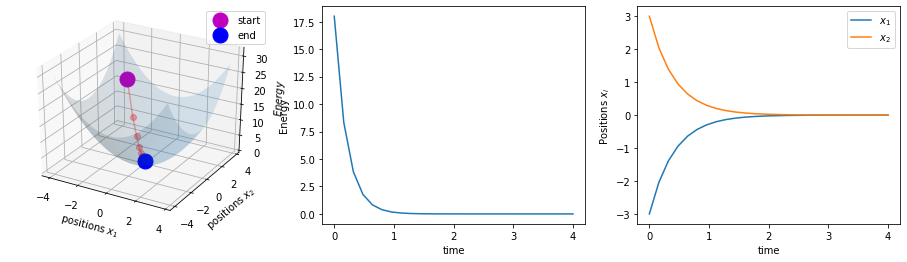

In [ ]:
o  = Vertex(torch.tensor([[0,0]],dtype=torch.float64)) # equilibrium point (where U(x) is minimum)
v1 = Vertex(torch.tensor([[-3,3]],requires_grad=True,dtype=torch.float64)) # particles location
r = o.dist(v1)
print(f'distance from origin (r):{r.item():.4f}')
# Define energy
k = 1.0
energy = lambda r: k*r**2
E = energy(r)
print(f'Energy=kr^2 :{E.item():.4f}')
# compute gradients
E.backward()
dEdx = v1.grad().data
dxdt = -dEdx
print(f't=0: dE/dx={dEdx.tolist()} --> dx/dt=-dE/dx={dxdt.tolist()}')
# Numerical integration
Dt = .16 # time step size
positions = [v1.x.tolist()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(25):
    v1.zero_grad_()
    E = energy(o.dist(v1))  # elastic energy, o.dist(v1) is distance from vertex "o"
    Energies.append(E.item())
    E.backward()   # compute gradients
    dxdt = -v1.grad().data# dx/dt=-dE/dx
    if n%5==0:
        print(f't={Dt*n:.2f}:r={o.dist(v1).item():4.3f}; E={E.item():.2g}; dx/dt={dxdt}')
    # Update vertex position
    with torch.no_grad():
        v1.x += dxdt*Dt
    positions.append(v1.x.tolist()); t.append(t[-1]+Dt)
Energies.append( energy(o.dist(v1)).item() )

# Display the results
positions = np.array(positions).squeeze() # convert to a np array
fig = plt.figure(figsize=plt.figaspect(0.25))
# Energy as a function of position
ax = fig.add_subplot(1, 3, 1, projection='3d')
# Plot the Energy surface
Xmesh,Ymesh = np.meshgrid(np.arange(-4,4,.25),np.arange(-4,4,.25))
Zmesh = k*((Xmesh-o.x[0,0].numpy())**2+(Ymesh-o.x[0,1].numpy())**2) # potential energy surface
ax.plot_surface(Xmesh,Ymesh, Zmesh, alpha=0.15)
# Plot trajectory of the vertex E,x1,x2
ax.plot(positions[:,0],positions[:,1],Energies,'ro-',alpha=.3)
ax.plot(positions[:1,0],positions[:1,1],Energies[:1],'mo',ms=15,label='start')
ax.plot(positions[-1:,0],positions[-1:,1],Energies[-1:],'bo',ms=15,label='end')
ax.set_xlabel('positions $x_1$'); ax.set_ylabel('positions $x_2$'); ax.set_zlabel('$Energy$'); plt.legend();
# Energy as function of time
ax = fig.add_subplot(1, 3, 2); ax.plot(t,Energies); ax.set_xlabel('time'); ax.set_ylabel('Energy')
# 
ax = fig.add_subplot(1, 3, 3)
ax.plot(t,positions);plt.legend(['$x_1$','$x_2$']); ax.set_ylabel('Positions $x_i$'); ax.set_xlabel('time');
plt.show()

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted index.ipynb.
